In [1]:
from dataclasses import dataclass
from enum import Enum
import os
import pandas as pd
import numpy as np

CONNECTOMES_ROOT = "connectomes-csv"

# Utility functions and classes:
class ConnectomeKind(Enum):
    FA = 0
    LN = 1
    NWS = 2
    WS = 3
    
@dataclass(frozen=True)
class Measurement:
    subject_ID: str
    kind: ConnectomeKind
    
    @classmethod
    def from_filename(cls, filename: str):
        subject_ID = filename.split("-")[1]
        kind_str = filename.split("-")[4].split(".")[0]
        kind_from_str = {
            "fa": ConnectomeKind.FA,
            "ln": ConnectomeKind.LN,
            "nws": ConnectomeKind.NWS,
            "ws": ConnectomeKind.WS
        }
        return Measurement(subject_ID, kind_from_str[kind_str])
    
def read_connectomes() -> dict[str, np.array]: # subject_ID -> (87, 87, 4)
    connectomes = {}
    
    for filename in os.listdir(CONNECTOMES_ROOT):
        m = Measurement.from_filename(filename)
        
        if m.subject_ID not in connectomes.keys():
            connectomes[m.subject_ID] = np.zeros(shape=(87, 87, 4), dtype=float)
            
        path = os.path.join(CONNECTOMES_ROOT, filename)
        connectomes[m.subject_ID][:, :, m.kind.value] = pd.read_csv(path, header=None).to_numpy()
        
    return connectomes
     
connectomes = read_connectomes()

In [2]:
class Sex(Enum):
    MALE = 0
    FEMALE = 1
    
@dataclass(frozen=True)
class Label:
    birth_age: float
    sex: Sex
    birth_weight: float
    
    @classmethod
    def from_row(cls, row: pd.Series):
        age = row["birth_age"]
        weight = row["birth_weight"]
        sex_dict = {
            "male": Sex.MALE,
            "female": Sex.FEMALE
        }
        sex = sex_dict[row["sex"]]
        return Label(age, sex, weight)
    

def read_labels(connectomes: dict[str, np.array]) -> dict[str, Label]:
    participants = pd.read_csv("participants.tsv", sep="\t")
    labels = {}
    
    for _, row in participants.iterrows():
        subject_ID = row["participant_id"]
        if subject_ID in connectomes.keys():
            labels[subject_ID] = Label.from_row(row)
    
    return labels
            
labels = read_labels(connectomes)

In [111]:
from sklearn.linear_model import LinearRegression

N = len(connectomes)
flattened_features = 87*87*4

X = np.zeros(shape=(N, flattened_features), dtype=float)
y_age = np.zeros(shape=(N,), dtype=float)

for i, k in enumerate(connectomes.keys()):
    X[i] = connectomes[k].reshape(-1)
    y_age[i] = labels[k].birth_age


lr = LinearRegression()
lr = lr.fit(X, y_age)

predictions = lr.predict(X)
MAE = np.max(np.absolute(predictions - y_age))
print(f"Age regression: Max. abs. error = {MAE}")

Age regression: Max. abs. error = 6.750155989720952e-14


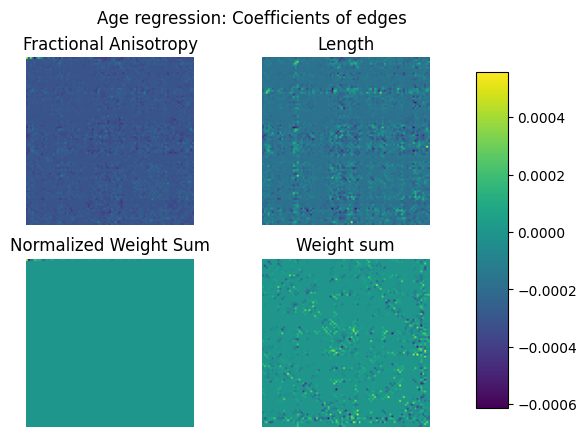

In [27]:
import matplotlib.pyplot as plt

coefs = lr.coef_.reshape((87, 87, 4))
titles = [
    "Fractional Anisotropy",
    "Length",
    "Normalized Weight Sum",
    "Weight sum"
]

fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(coefs[:, :, i])
    ax.axis("off")
    ax.set_title(titles[i])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle("Age regression: Coefficients of edges");

In [113]:
y_weight = np.zeros(shape=(N,), dtype=float)

for i, k in enumerate(connectomes.keys()):
    y_weight[i] = labels[k].birth_weight

no_outliers_idx = (y_weight > 0) & (y_weight < 5)

lr = LinearRegression()
lr = lr.fit(X[no_outliers_idx], y_weight[no_outliers_idx])

predictions = lr.predict(X[no_outliers_idx])
MAE = np.max(np.absolute(predictions - y_weight[no_outliers_idx]))
print(f"Weight regression: Max. abs. error = {MAE}")

Weight regression: Max. abs. error = 1.7985612998927536e-14


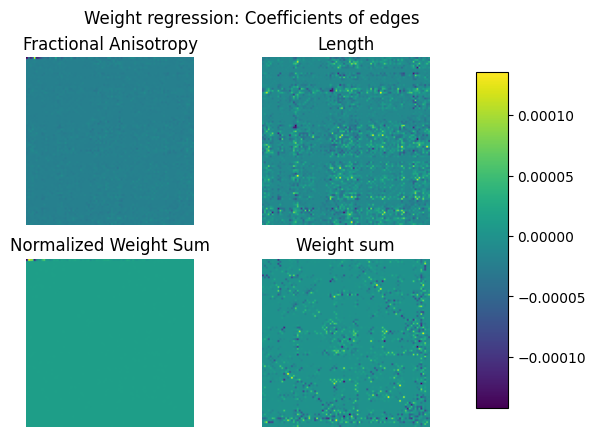

In [29]:
coefs = lr.coef_.reshape((87, 87, 4))
titles = [
    "Fractional Anisotropy",
    "Length",
    "Normalized Weight Sum",
    "Weight sum"
]

fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(coefs[:, :, i])
    ax.axis("off")
    ax.set_title(titles[i])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle("Weight regression: Coefficients of edges");

In [114]:
from sklearn.naive_bayes import GaussianNB

y_sex = np.zeros(shape=(N,), dtype=int)

for i, k in enumerate(connectomes.keys()):
    y_sex[i] = labels[k].sex.value

classifier = GaussianNB()
classifier = classifier.fit(X, y_sex)
Acc = classifier.score(X, y_sex)
print(f"Sex classification: Mean Acc. = {Acc}")


Sex classification: Mean Acc. = 0.978494623655914


Lowest KL divergence: 2.5395275475161596


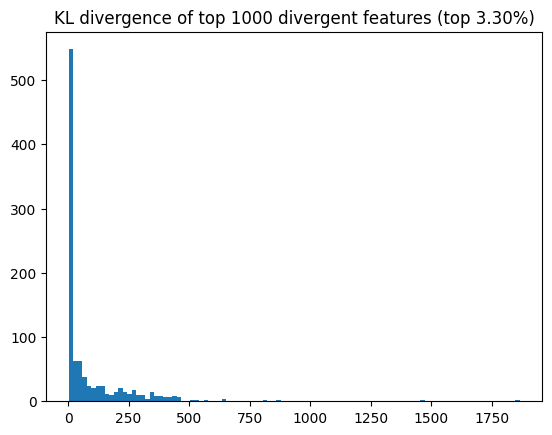

In [108]:
# Mean KL divregence between classes
mu_M, mu_F = classifier.theta_.reshape((2, 87, 87, 4))
var_M, var_F = classifier.var_.reshape((2, 87, 87, 4))
# KL divregence per feature - GaussianNB supposes independent features, so no covariance mx, needed
KL = np.log(np.sqrt(var_F) / np.sqrt(var_M)) + (var_M + np.power(mu_M - mu_F, 2)) / (2 * var_F) - 0.5 # shape 87, 87, 4
# Find the arguments of the top K highest divergences
K = 1000
top_k_indexes = np.argpartition(KL, -K, axis=None)[-K:]
# for idx in top_k_indexes:
#     k, j, i = idx % 4, (idx // 4) % 87, (idx // (4 * 87)) % 87
#     print(f"Value: {KL[i, j, k]} at {i, j, k}")
top_k_values = KL.reshape(-1)[top_k_indexes]
# x, bins = np.histogram(top_k_values)
plt.hist(top_k_values, bins=100);
plt.title(f"KL divergence of top {K} divergent features (top {K / KL.reshape(-1).shape[0] * 100:.2f}%)")
print(f"Lowest KL divergence: {top_k_values.min()}")
# top_k_values = flat_KL[top_k_indexes]
# plt.hist(*np.histogram(top_k_values))

In [ ]:
# theta = classifier.theta_.reshape((2, 87, 87, 4))
# titles = [
#     "Fractional Anisotropy",
#     "Length",
#     "Normalized Weight Sum",
#     "Weight sum"
# ]
# sexes = [
#     "male",
#     "female"
# ]
# fig, axes = plt.subplots(4, 2)
# for feature_idx in range(4):
#     for sex_idx in range(2):
#         ax = axes[feature_idx, sex_idx]
#         im = ax.imshow(
#             theta[sex_idx, :, :, feature_idx]
#         )
#         ax.set_title(
#             f"{titles[feature_idx]} - {sexes[sex_idx]}"
#         )
#         ax.axis("off")
    
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)

# fig.suptitle("Sex classification: Mean features of male and female classes");